## Image Denoising

In [1]:
from keras.datasets import mnist
from keras.backend.tensorflow_backend import set_session

import tensorflow as tf
import numpy as np

# To avoid hogging the GPU
####
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
####


(x_train, _),(x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Using TensorFlow backend.


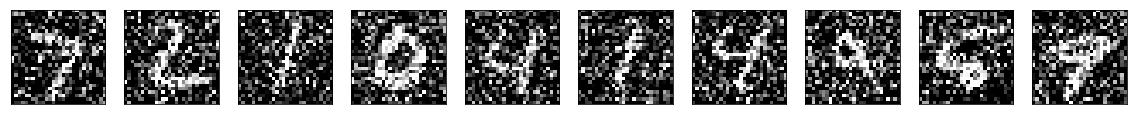

In [2]:
import matplotlib.pyplot as plt
n = 10

plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img  = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [4]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train_noisy, x_train,
               epochs = 100,
               batch_size = 128,
               shuffle = True,
               validation_data=(x_test_noisy, x_test),
               callbacks = [TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s - loss: 0.2004 - val_loss: 0.1323
Epoch 2/100
60000/60000 [==============================] - 6s - loss: 0.1267 - val_loss: 0.1193
Epoch 3/100
60000/60000 [==============================] - 6s - loss: 0.1167 - val_loss: 0.1142
Epoch 4/100
60000/60000 [==============================] - 6s - loss: 0.1118 - val_loss: 0.1084
Epoch 5/100
60000/60000 [==============================] - 6s - loss: 0.1087 - val_loss: 0.1054
Epoch 6/100
60000/60000 [==============================] - 6s - loss: 0.1067 - val_loss: 0.1039
Epoch 7/100
60000/60000 [==============================] - 6s - loss: 0.1052 - val_loss: 0.1062
Epoch 8/100
60000/60000 [==============================] - 6s - loss: 0.1042 - val_loss: 0.1021
Epoch 9/100
60000/60000 [==============================] - 6s - loss: 0.1035 - val_loss: 0.1027
Epoch 10/100
60000/60000 [==============================] - 6s - loss: 0.1028 - val_lo

60000/60000 [==============================] - 6s - loss: 0.0948 - val_loss: 0.0953
Epoch 86/100
60000/60000 [==============================] - 6s - loss: 0.0948 - val_loss: 0.0943
Epoch 87/100
60000/60000 [==============================] - 6s - loss: 0.0947 - val_loss: 0.0943
Epoch 88/100
60000/60000 [==============================] - 6s - loss: 0.0947 - val_loss: 0.0940
Epoch 89/100
60000/60000 [==============================] - 6s - loss: 0.0947 - val_loss: 0.0941
Epoch 90/100
60000/60000 [==============================] - 6s - loss: 0.0947 - val_loss: 0.0941
Epoch 91/100
60000/60000 [==============================] - 6s - loss: 0.0947 - val_loss: 0.0940
Epoch 92/100
60000/60000 [==============================] - 6s - loss: 0.0946 - val_loss: 0.0941
Epoch 93/100
60000/60000 [==============================] - 6s - loss: 0.0946 - val_loss: 0.0942
Epoch 94/100
60000/60000 [==============================] - 6s - loss: 0.0946 - val_loss: 0.0941
Epoch 95/100
60000/60000 [=================

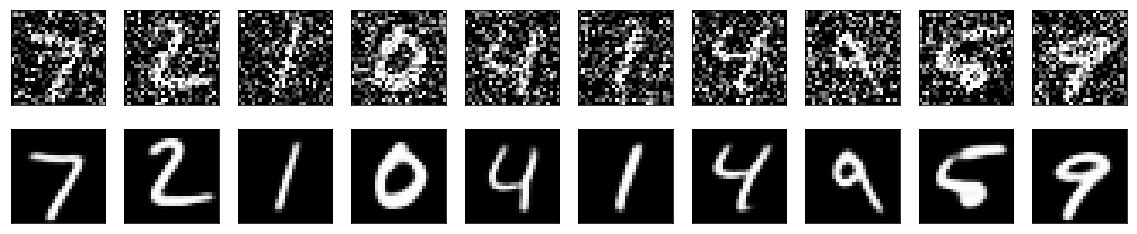

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
autoencoder.save('./models/autoencoder-denoise-model.h5')